## Problems

### Conversion
1.	Is it possible to predict customer conversion (from viewing to purchasing)?
2.	Can we identify “new customers”? If yes then what is the best strategy to work with them?
3.	What are the top features that define customer conversion?
4.	Can we explain and visualize the predictive model for customer conversion on a journey and at a session level?
5.	Is there a pattern and trend across product types regarding the conversion event?

### Personalization
1.	Can we personalize the experience from customer-product interactions?
2.	Does the product catalogue information help in improving customer experience?
3.	Can personalized shopping experience be predictively modeled?
4.	Can we apply transfer learning from other E-commerce data sets to our local data set?

In [91]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip install -r requirements.txt
!pip install tensorflow-addons
!pip install shap

Found existing installation: Keras 2.4.0
Uninstalling Keras-2.4.0:
  Successfully uninstalled Keras-2.4.0
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: tensorflow 2.3.0
Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
  Using cached Keras-2.4.0-py2.py3-none-any.whl (170 kB)
  Using cached tensorflow-2.3.0-cp36-cp36m-manylinux2010_x86_64.whl (320.4 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)


## Preprocessing

In [1]:
from groupby_user_conversion import GroupBy, FeatureSelection, Evaluation

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
Using TensorFlow backend.


In [2]:
g = GroupBy('raw_data.json')
preprocessed_data = g.preprocessing_for_bin_class()

Feature "uniqueRefinements" is highly related to "totalRefinements". Remove "uniqueRefinements"
Feature "uniqueViewProducts" is highly related to "totalViewProducts". Remove "uniqueViewProducts"
Feature "events" is highly related to "totalViewProducts". Remove "events"
Feature "totalViewProductRevenue" is highly related to "totalViewProducts". Remove "totalViewProductRevenue"
Feature "has_campaign" is highly related to "source". Remove "has_campaign"
Feature "uniqueNavigations" is highly related to "uniqueRefinements". Remove "uniqueNavigations"
Feature "totalAddToCartRevenue" is highly related to "uniqueAddToCarts". Remove "totalAddToCartRevenue"
Feature "totalAddToCarts" is highly related to "uniqueAddToCarts". Remove "totalAddToCarts"
Feature "sessionDuration" is highly related to "timeOnSiteSeconds". Remove "sessionDuration"
Feature "totalSearches" is highly related to "events". Remove "totalSearches"
28


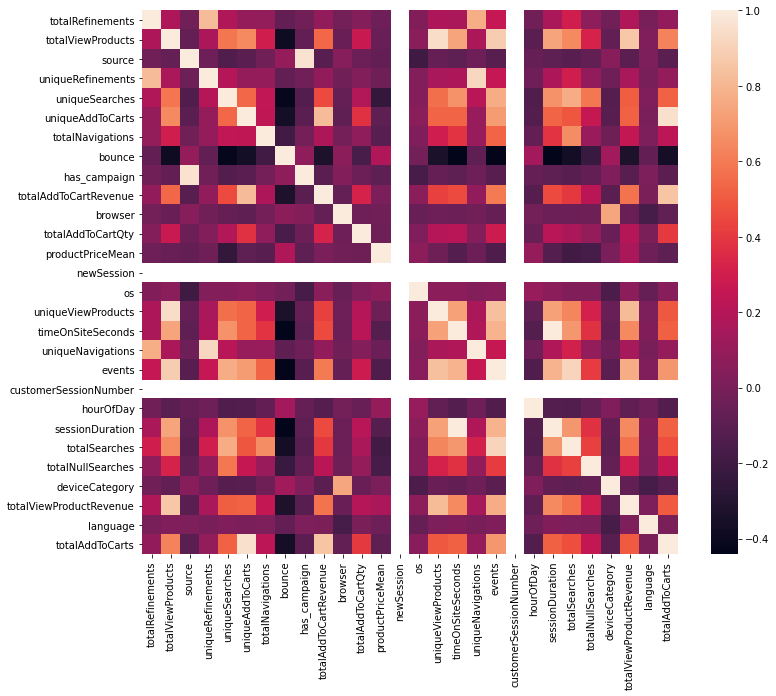

               score            feature
feature 1   0.140467  totalViewProducts
feature 9   0.075170   productPriceMean
feature 12  0.072320  timeOnSiteSeconds
feature 4   0.052830   uniqueAddToCarts
feature 8   0.044547  totalAddToCartQty
feature 3   0.029778     uniqueSearches
feature 14  0.016220          hourOfDay


In [3]:
# Select features
new_features = FeatureSelection.by_coorelation(preprocessed_data['features'], debug=True)
new_features = FeatureSelection.by_permutation_importance(x=new_features, y=preprocessed_data['label'], debug=True)

In [4]:
conversion_rate = preprocessed_data['label'][preprocessed_data['label']['has_purchase']==1].count()*100/len(preprocessed_data['label'])
print(f'Conversion Rate is: {conversion_rate["has_purchase"]}%')
      

Conversion Rate is: 8.651304148712505%


In [5]:
scale_pos_weight = preprocessed_data['label'][preprocessed_data['label']['has_purchase']==0].count() / preprocessed_data['label'][preprocessed_data['label']['has_purchase']==1].count()
scale_pos_weight

has_purchase    10.558951
dtype: float64

## XGBoost Model Training

In [6]:
xgb_model, test_x, test_y, train_x, train_y = GroupBy.train_xgb_bin_class(new_features, preprocessed_data['label'])

In [7]:
Evaluation.evaluate_model(test_x, test_y, xgb_model)

,0,1,accuracy,macro avg,weighted avg
precision,0.972025,0.714179,0.95023,0.843102,0.949856
recall,0.973568,0.702128,0.95023,0.837848,0.950230
f1-score,0.972796,0.708102,0.95023,0.840449,0.950038
support,14490.000000,1363.000000,0.95023,15853.000000,15853.000000


In [8]:
xgb_model.save_model('xgboost_model')

In [9]:
from xgboost import XGBClassifier
x = XGBClassifier()
x.load_model('xgboost_model')

NameError: name 'plt' is not defined

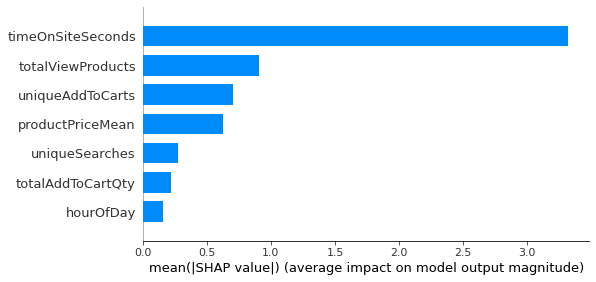

In [17]:
import shap
import pandas as pd
shap_values = shap.TreeExplainer(x).shap_values(train_x)
shap.summary_plot(shap_values, pd.DataFrame(train_x,columns=new_features.columns), plot_type="bar",show=False)
plt.savefig('grafic.png')

## Sequential Model Training

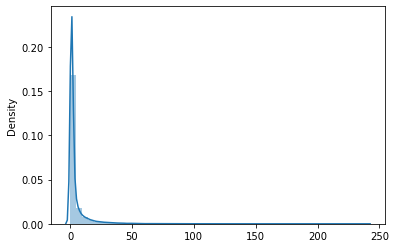

In [36]:
preprocessed_data_for_lstm = g.preprocessing_for_sequence_model(num_of_events=40, debug=True)

Epoch 1/100
27/27 [==============================] - 1s 47ms/step - loss: 0.6627 - f1_score: 0.5333 - val_loss: 0.6234 - val_f1_score: 0.4908
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 0.5821 - f1_score: 0.5019 - val_loss: 0.5332 - val_f1_score: 0.4997
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.4853 - f1_score: 0.5432 - val_loss: 0.4346 - val_f1_score: 0.5754
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 0.3947 - f1_score: 0.5947 - val_loss: 0.3541 - val_f1_score: 0.5620
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 0.3302 - f1_score: 0.5672 - val_loss: 0.3040 - val_f1_score: 0.5266
Epoch 6/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2922 - f1_score: 0.5572 - val_loss: 0.2765 - val_f1_score: 0.5751
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2706 - f1_score: 0.5617 - val_loss: 0.2600 - val_f1_score: 0.5841
Epoch 

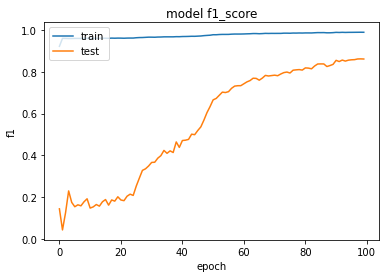

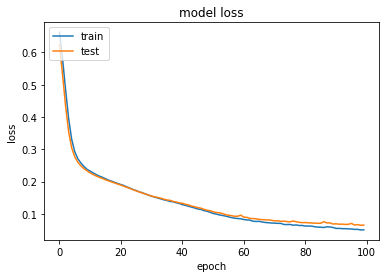

Accuracy: 0.969139
Precision: 0.837374
Recall: 0.750906
F1 score: 0.791786


In [30]:
lstm_model, test_x, test_y = GroupBy.train_lstm(
    preprocessed_data_for_lstm['features'], preprocessed_data_for_lstm['label'], threshold=0.5, epochs=100,op=35)
Evaluation.plot_history(lstm_model.history)
Evaluation.evaluate_nn_model(test_x, test_y, lstm_model)

Epoch 1/100
27/27 [==============================] - 1s 47ms/step - loss: 0.6479 - f1_score: 0.0000e+00 - val_loss: 0.6020 - val_f1_score: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 0.5559 - f1_score: 0.0022 - val_loss: 0.5027 - val_f1_score: 0.0150
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.4573 - f1_score: 0.1005 - val_loss: 0.4105 - val_f1_score: 0.1772
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 0.3746 - f1_score: 0.2105 - val_loss: 0.3428 - val_f1_score: 0.2603
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 0.3178 - f1_score: 0.4075 - val_loss: 0.3022 - val_f1_score: 0.4666
Epoch 6/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2842 - f1_score: 0.4671 - val_loss: 0.2789 - val_f1_score: 0.4646
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2649 - f1_score: 0.4665 - val_loss: 0.2641 - val_f1_score: 0.463

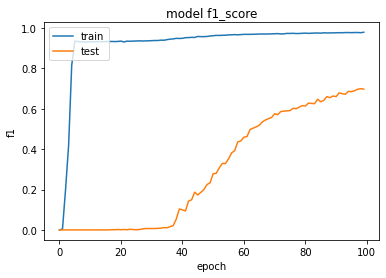

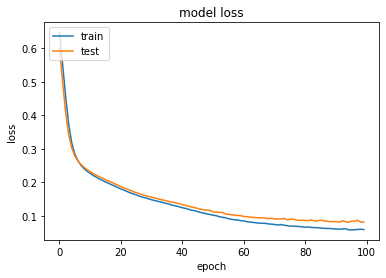

Accuracy: 0.965529
Precision: 0.870700
Recall: 0.660072
F1 score: 0.750895


In [31]:
lstm_model, test_x, test_y = GroupBy.train_lstm(
    preprocessed_data_for_lstm['features'], preprocessed_data_for_lstm['label'], threshold=0.8, epochs=100,op=35)
Evaluation.plot_history(lstm_model.history)
Evaluation.evaluate_nn_model(test_x, test_y, lstm_model)

Epoch 1/100
27/27 [==============================] - 1s 47ms/step - loss: 0.6659 - f1_score: 0.0000e+00 - val_loss: 0.6258 - val_f1_score: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 0.5824 - f1_score: 0.0000e+00 - val_loss: 0.5344 - val_f1_score: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.4832 - f1_score: 7.3746e-04 - val_loss: 0.4366 - val_f1_score: 0.0051
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 0.3922 - f1_score: 0.0762 - val_loss: 0.3611 - val_f1_score: 0.1387
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 0.3280 - f1_score: 0.1527 - val_loss: 0.3150 - val_f1_score: 0.1617
Epoch 6/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2901 - f1_score: 0.1906 - val_loss: 0.2892 - val_f1_score: 0.2064
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2672 - f1_score: 0.3419 - val_loss: 0.2729 - val_f1_

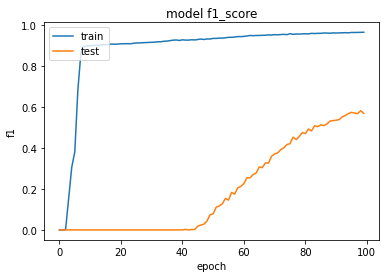

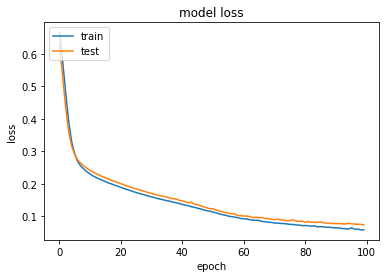

Accuracy: 0.966603
Precision: 0.821833
Recall: 0.726115
F1 score: 0.771014


In [38]:
lstm_model, test_x, test_y = GroupBy.train_lstm(
    preprocessed_data_for_lstm['features'], preprocessed_data_for_lstm['label'], threshold=0.9, epochs=100,op=40)
Evaluation.plot_history(lstm_model.history)
Evaluation.evaluate_nn_model(test_x, test_y, lstm_model)